In [1]:
import gzip
import csv
import json
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
import datetime
import scipy.optimize as sco
from scipy import stats
%matplotlib inline
import scipy
#import pandas_profiling as pp
from sqlalchemy import create_engine
import matplotlib
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.base import TransformerMixin
from sklearn.base import TransformerMixin, BaseEstimator
#from sklearn_pandas import CategoricalImputer
from scipy.stats import norm
#from __future__ import division
import random
import math
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
#!pip install imblearn
#from imblearn.under_sampling import RandomUnderSampler
#import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
Ret36 = pd.read_excel('Rett36_bal_amor.xlsx')
Ret36 = Ret36/100

In [3]:
Ret36

,Grade_A,Grade_B,Grade_C,Grade_D,Grade_E,Grade_F,Grade_G
0,0.115035,0.172466,0.258733,0.328187,0.419386,0.444524,0.544867
1,0.126283,0.197780,0.248304,0.329101,0.401066,0.528060,0.544867
2,0.127445,0.162971,0.268143,0.332759,0.401066,0.461416,0.547843
3,0.115035,0.212809,0.258733,0.323260,0.412194,0.502541,0.546850
4,0.127611,0.174336,0.266009,0.354270,0.401066,0.537935,0.502150
...,...,...,...,...,...,...,...
1316,0.117345,0.192279,0.268143,0.337706,0.412194,0.502541,0.547843
1317,0.125454,0.185254,0.268143,0.337706,0.410115,0.543083,0.544867
1318,0.112728,0.172466,0.248833,0.337889,0.455069,0.543083,0.543876
1319,0.126283,0.164325,0.273844,0.323260,0.456414,0.531611,0.521757


In [4]:
Cova_matrix_Ret36 = Ret36.cov()
Corr_matrix_Ret36 = Ret36.corr()
#Daily return
Daily_mean_Ret36 = np.mean(Ret36)
Daily_mean_Ret36.values

array([0.12472123, 0.18524115, 0.26144643, 0.34266363, 0.42701993,
       0.49490972, 0.53347328])

In [5]:
Annual_return_Ret36  =  ((Daily_mean_Ret36 + 1)**12 -1)

In [6]:
Rmin = 0.22# Enter the minimum return for an admissible portfolio (in decimals)
Rmax = 0.50#np.mean(Ret36.median().values) # Pull the slider to change the value of Rmax
R = np.arange(Rmin, Rmax, 0.5/100)
R

array([0.22 , 0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 ,
       0.265, 0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305,
       0.31 , 0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 ,
       0.355, 0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395,
       0.4  , 0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 ,
       0.445, 0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485,
       0.49 , 0.495, 0.5  ])

In [7]:
from numpy.linalg import inv
A_Ret36 = np.dot(np.ones(Cova_matrix_Ret36.shape[0]), np.dot(np.linalg.inv(Cova_matrix_Ret36), Daily_mean_Ret36.values)) 
B_Ret36 = np.dot(np.transpose(Daily_mean_Ret36.values), (np.dot(np.linalg.inv(Cova_matrix_Ret36) ,Daily_mean_Ret36.values)))
C_Ret36 = np.dot(np.transpose(np.ones(Cova_matrix_Ret36.shape[0])), (np.dot(np.linalg.inv(Cova_matrix_Ret36),np.ones(Cova_matrix_Ret36.shape[0]))))
D_Ret36 = np.dot(B_Ret36,C_Ret36) - A_Ret36**2

In [8]:
Port_vol_Ret36 = np.zeros((len(R),1))
Port_vol_annual_Ret36 = np.zeros((len(R),1))
Port_var_Ret36 = np.zeros((len(R),1))
#Port_val_Ret36 = np.zeros((len(R),1))
port_weight_Ret36 = []
for i in range(0, len(R)):
    P1_Ret36 = B_Ret36*(np.dot(np.linalg.inv(Cova_matrix_Ret36.values),np.ones(Cova_matrix_Ret36.shape[0]))) - A_Ret36*(np.dot(np.linalg.inv(Cova_matrix_Ret36.values),Daily_mean_Ret36.values))
    P2_Ret36 = C_Ret36*(np.dot(np.linalg.inv(Cova_matrix_Ret36.values),Daily_mean_Ret36.values)) - A_Ret36*(np.dot(np.linalg.inv(Cova_matrix_Ret36),np.ones(Cova_matrix_Ret36.shape[0])))
    w_Ret36 = (1/D_Ret36)*(P1_Ret36) + (1/D_Ret36)*(P2_Ret36)*R[i]
    #print(w)
    port_weight_Ret36.append(w_Ret36)
    Port_var_Ret36[i] = np.dot(w_Ret36,np.dot((Cova_matrix_Ret36.values),w_Ret36))
      

In [9]:
print(port_weight_Ret36[1], sum(port_weight_Ret36[1]))

[0.42982583 0.13006347 0.24048083 0.08037465 0.05791779 0.0147747
 0.04656273] 0.9999999999999999


In [10]:
Distribution_df_Ret36 = pd.DataFrame(port_weight_Ret36,columns=Cova_matrix_Ret36.columns)

In [11]:
mean_mvo = Distribution_df_Ret36.mean()
cov_mvo = Distribution_df_Ret36.cov()
Distribution_df_Ret36['Expected return'] = R.T
Distribution_df_Ret36['Volatility'] = np.sqrt(Port_var_Ret36)

In [12]:
def Sharpe_ratio(Rp,Rf,Sig):
    Sharpe = []
    for i in range(0,len(Rp)):
        Sharpe.append((Rp[i] - Rf)/Sig[i])
    return Sharpe

In [13]:
SR_Ret36 = Sharpe_ratio(Distribution_df_Ret36['Expected return'],0.10,Distribution_df_Ret36['Volatility'])
Distribution_df_Ret36['Sharpe ratio'] = SR_Ret36

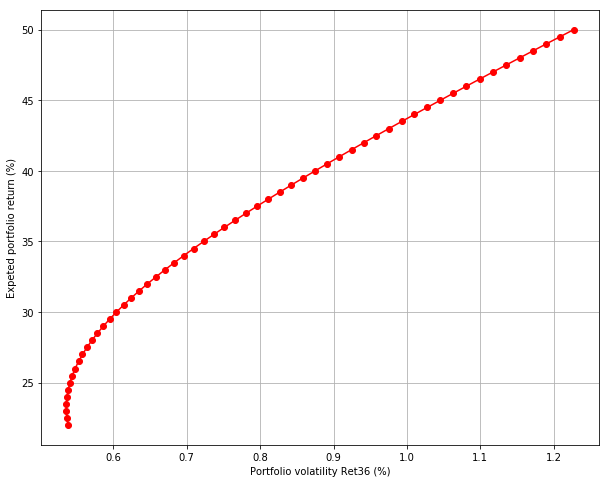

In [14]:
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,8))
plt.plot(Distribution_df_Ret36['Volatility']*100,Distribution_df_Ret36['Expected return']*100,'ro-')
#plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio volatility Ret36 (%)')
plt.ylabel('Expeted portfolio return (%)')
#plt.xlim([0.17, 0.34])
plt.grid()

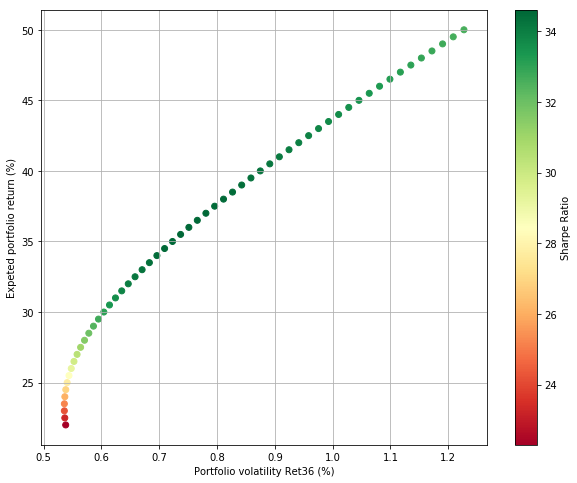

In [15]:
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,8))
plt.scatter(Distribution_df_Ret36['Volatility']*100,Distribution_df_Ret36['Expected return']*100,c=Distribution_df_Ret36['Sharpe ratio'],\
            cmap='RdYlGn')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio volatility Ret36 (%)')
plt.ylabel('Expeted portfolio return (%)')
#plt.xlim([0.17, 0.34])
plt.grid()

In [16]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['Returns','Volatility','Sharpe_ratio'] + [ticker for ticker in tickers])
        
    return results_df

In [17]:
#cov_mvo
#mean_returns_Ret36 = mean_mvo.values
mean_returns_Ret36 = Ret36.mean().values
cov_Ret36 = Ret36.cov()
num_portfolios = 3000
rf = 0.10
tickers = Ret36.columns 
results_frame_Ret36 = simulate_random_portfolios(num_portfolios, mean_returns_Ret36, cov_Ret36, rf)


In [18]:
print('Max sharpe ratio in the array (Ret36): {}'.format(results_frame_Ret36.Sharpe_ratio.max()))
print('Its location in the array is (Ret36): {}'.format(results_frame_Ret36.Volatility.argmax()))

Max sharpe ratio in the array (Ret36): 34.378794781991594
Its location in the array is (Ret36): 1044


In [19]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port_Ret36 = results_frame_Ret36.iloc[results_frame_Ret36['Sharpe_ratio'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port_Ret36 = results_frame_Ret36.iloc[results_frame_Ret36['Volatility'].idxmin()]

In [20]:
max_sharpe_port_Ret36

Returns          0.380048
Volatility       0.008146
Sharpe_ratio    34.378795
Grade_A          0.010536
Grade_B          0.062875
Grade_C          0.291114
Grade_D          0.130607
Grade_E          0.190988
Grade_F          0.072093
Grade_G          0.241788
Name: 737, dtype: float64

In [21]:
min_vol_port_Ret36

Returns          0.235043
Volatility       0.005469
Sharpe_ratio    24.693100
Grade_A          0.344078
Grade_B          0.162890
Grade_C          0.272513
Grade_D          0.098292
Grade_E          0.066642
Grade_F          0.028103
Grade_G          0.027482
Name: 971, dtype: float64

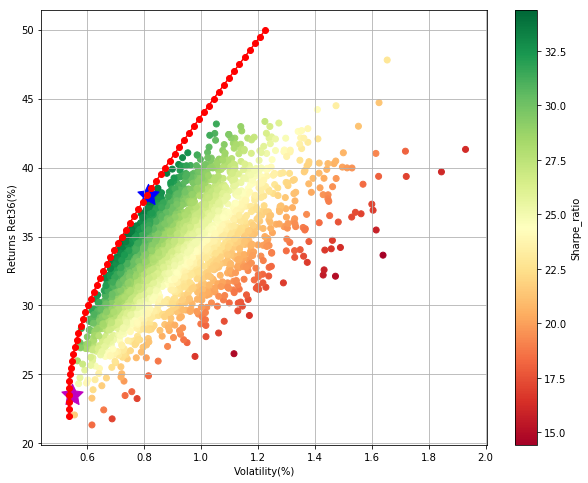

In [22]:
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,8))
plt.scatter(results_frame_Ret36.Volatility*100,results_frame_Ret36.Returns*100,c=results_frame_Ret36.Sharpe_ratio,cmap='RdYlGn')
#plt.plot(results_frame.Returns,results_frame.Volatility)
plt.colorbar(label='Sharpe_ratio')
plt.xlabel('Volatility(%)')
plt.ylabel('Returns Ret36(%)')
plt.plot(Distribution_df_Ret36['Volatility']*100,Distribution_df_Ret36['Expected return']*100,'ro-')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port_Ret36[1]*100,max_sharpe_port_Ret36[0]*100,marker=(5,1,0),color='b',s=500)

#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port_Ret36[1]*100,min_vol_port_Ret36[0]*100,marker=(5,1,0),color='m',s=500)
plt.grid()
plt.show()


In [23]:
def get_ret_vol_sr_Ret36(weights_Ret36):
    weights_Ret36 = np.array(weights_Ret36)
    ret_Ret36 = np.sum(Ret36.mean()*weights_Ret36)
    vol_Ret36 = np.sqrt(np.dot(weights_Ret36.T, np.dot(Ret36.cov(), weights_Ret36)))
    sr_Ret36 = (ret_Ret36 - rf)/vol_Ret36
    return np.array([ret_Ret36, vol_Ret36, sr_Ret36])

def neg_sharpe_Ret36(weights_Ret36):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return (-1)*get_ret_vol_sr_Ret36(weights_Ret36)[2]

def check_sum_Ret36(weights_Ret36):
    #return 0 if sum of the weights is 1
    return np.sum(weights_Ret36)-1


In [24]:

cons_Ret36 = ({'type':'eq','fun':check_sum_Ret36})
bound = (0.0,1.0)
bounds = tuple(bound for asset in range(len(tickers)))
init_guess = len(tickers)*[1./len(tickers),]


In [25]:
from scipy.optimize import minimize
opt_results_Ret36 = minimize(neg_sharpe_Ret36,init_guess,method='SLSQP',bounds=bounds,constraints=cons_Ret36)

In [26]:
def minimize_volatility_Ret36(weights_Ret36):
    return get_ret_vol_sr_Ret36(weights_Ret36)[1]

In [27]:
frontier_x = []
for possible_return in R:
    cons_Ret36 = ({'type':'eq', 'fun':check_sum_Ret36},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr_Ret36(w)[0] - possible_return})
    
    result = minimize(minimize_volatility_Ret36,init_guess,method='SLSQP', bounds=bounds, constraints=cons_Ret36)
    frontier_x.append(result['fun'])



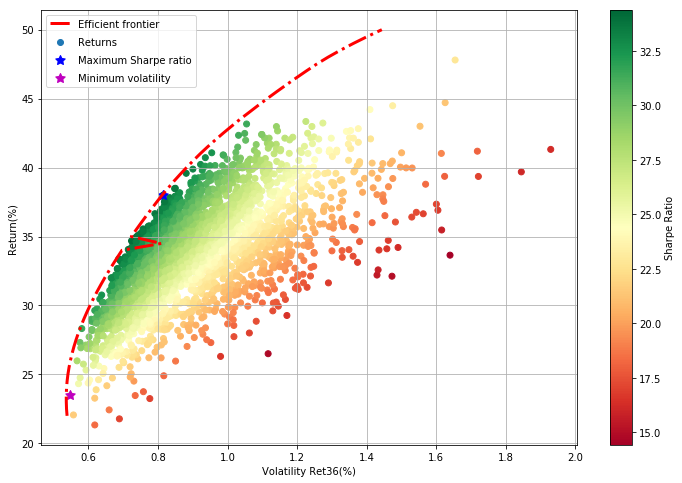

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(results_frame_Ret36.Volatility*100,results_frame_Ret36.Returns*100,c=results_frame_Ret36.Sharpe_ratio,cmap='RdYlGn')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_port_Ret36[1]*100,max_sharpe_port_Ret36[0]*100,marker=(5,1,0),color='b',s=100,label='Maximum Sharpe ratio')
plt.scatter(min_vol_port_Ret36[1]*100,min_vol_port_Ret36[0]*100,marker=(5,1,0),color='m',s=100,label='Minimum volatility')
plt.xlabel('Volatility Ret36(%)')
plt.ylabel('Return(%)')
plt.plot([i*100 for i in frontier_x],[i*100 for i in R], 'r-.', linewidth=3, label='Efficient frontier')
plt.grid()
plt.legend(labelspacing=0.8)
plt.show()

In [29]:
class Particle:
    def __init__(self, num_port):
        self.position =  Particle.initial_swarm(num_port)
        self.pbest_position = self.position
        self.pbest_value = 0.001645 
        self.velocity = np.zeros(num_port)

    def move(self):
        proxy = self.position + self.velocity
        proxy = np.where(proxy>1, 1, proxy) # upper bound
        proxy = np.where(proxy<0, 0, proxy) # lower bound
        # print(proxy)
        self.position = proxy/np.sum(proxy)

    @staticmethod
    def initial_swarm(x):
        array = np.array([random.random() for i in range(x)])
        sum1 = np.sum(array)
        return array/sum1 # normalized weights

In [30]:
class Space:
    def __init__(self, n_particles, num_port, returns, vol, alpha, w, c1, c2):
        self.n_particles = n_particles
        self.particles = []
        self.gbest_value = 0.001645
        self.alpha = alpha #sensitivity to sharpe
        self.n_stocks = num_port        
        self.gbest_position = Space.initial_swarm(num_port)
        self.returns = returns
        self.vol = vol #volatility matrix (variance)
        self.w = w
        self.c1 = c1
        self.c2 = c2

    @staticmethod
    def initial_swarm(x):
        array = np.array([random.random() for i in range(x)])
        sum1 = np.sum(array)
        return array/sum1 # normalized weights
    
    def get_ret_vol_sr_Ret36(self, particle):
        #particle = np.array(particle)
        return_ = np.dot(particle.position,np.transpose(self.returns))
        vol = np.dot(np.dot(particle.position,self.vol),np.transpose(particle.position))
        self.sharpe = (return_ - rf)/np.sqrt(vol) 
        return np.array([return_, vol, self.sharpe])

    def neg_sharpe_Ret36(self, particle):
        # the number 2 is the sharpe ratio index from the get_ret_vol_sr
        return (-1)*get_ret_vol_sr_Ret36(particle)[2]

    def check_sum_Ret36(self, particle):
        #return 0 if sum of the weights is 1
        return np.sum(particle)-1
    
    def minimize_volatility_Ret36(self, particle):
        return get_ret_vol_sr_Ret36(particle)[1]
    
    # fitness function for portfolio optimization
    def fitness(self, particle):
        return_ = np.dot(particle.position,np.transpose(self.returns))
        vol = np.dot(np.dot(particle.position,self.vol),np.transpose(particle.position))
        self.sharpe = (return_ - rf)/np.sqrt(vol) 
       
        # w\cdot covariance\:matrix\times w^{T}
        vols = np.dot(particle.position,self.vol)*particle.position
        
        # volatility\:dispersion=\sum (stock\:risk\:contibution_{i} -average\:risk)
        self.vol_dis = np.sqrt(vols) #np.sum(abs(np.sqrt(vols)-np.mean(np.sqrt(vols))))
        
        cons_Ret36 = ({'type':'eq','fun':check_sum_Ret36})
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(len(tickers)))
        init_guess = len(tickers)*[1./len(tickers),]
        opt_results_Ret36 = minimize(neg_sharpe_Ret36,init_guess
                                     ,method='SLSQP',bounds=bounds,constraints=cons_Ret36)

        frontier_x = []
        for possible_return in R:
            cons_Ret36 = ({'type':'eq', 'fun':check_sum_Ret36},
                      {'type':'eq', 'fun': lambda w: get_ret_vol_sr_Ret36(w)[0] - possible_return})
            
            result = minimize(minimize_volatility_Ret36,init_guess,method='SLSQP', bounds=bounds, constraints=cons_Ret36)
            frontier_x.append(result['fun'])
        # \frac{Sharpe\times\alpha+1 }{volaltility\:dispersion\times(1-\alpha)+1}
        #result = minimize_volatility_Ret36(particle)
        #sharpe #(return_ - rf)/np.sqrt(self.vol_dis) 
        #(self.sharpe*self.alpha+1)/(self.vol_dis*(1-self.alpha)+1)
        #print(return_,vol,self.sharpe)
        return result
   

    def set_pbest(self):
        for particle in self.particles:
            fitness_candidate = self.fitness(particle)
            if (particle.pbest_value < fitness_candidate):
                particle.pbest_value = fitness_candidate
                particle.pbest_position = particle.position

    def set_gbest(self):
        for particle in self.particles:
            best_fitness_candidate = self.fitness(particle)
            if(self.gbest_value < best_fitness_candidate):
                self.gbest_value = best_fitness_candidate
                self.gbest_position = particle.position

    def move_particles(self):
        for particle in self.particles:
            new_velocity = (self.w*particle.velocity) + (self.c1*random.random()) * (particle.pbest_position - particle.position) + \
                            (random.random()*self.c2) * (self.gbest_position - particle.position)
            particle.velocity = new_velocity
            particle.move()

In [31]:
import pandas as pd
import os
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import matplotlib.ticker as mtick

cov_matrix = Cova_matrix_Ret36
returns = Daily_mean_Ret36
rf = 0.10


dic_pos = {}
best_values = []

for a in range(0,100,1):
    alpha = a/100
    search_space = Space(30, 7, returns, cov_matrix, alpha, w=0.5, c1=0.8, c2=0.9)
    particles_vector = [Particle(search_space.n_stocks) for _ in range(search_space.n_particles)]
    search_space.particles = particles_vector
    n_iterations =1000
        # algo
    iteration = 0
    prev_gbest_value = 0.001645
    while(iteration < n_iterations):
        search_space.set_pbest()    
        search_space.set_gbest()

        if(abs(search_space.gbest_value - prev_gbest_value) < 0.001645) and (iteration>3):
            break
        prev_gbest_value = search_space.gbest_value
        print('Iteration: {0} Position {1}, Value: {2:.3f}'.format(iteration, 
                                                                search_space.gbest_position, search_space.gbest_value))
        search_space.move_particles()
        iteration += 1
    print('finished {} ---------'.format(alpha))
        
    best_values.append(search_space.gbest_value)
    sharpes.append(search_space.sharpe)
    disp.append(search_space.vol_dis)
    #return_.append(search_space.return_)
    dic_pos[a] = search_space.gbest_position
    


a = np.array(list(dic_pos.values()))
A = a[:,0]
B = a[:,1]
C = a[:,2]
D = a[:,3]
E = a[:,4]
F = a[:,5]
G = a[:,6]
#ret = a[:,7]
#vol = a[:,8]
#sharp = a[:,9]
etf_list = [A, B, C, D, E, F, G]#, ret, vol, sharp]
etf_list_sf = [savgol_filter(i, 9, 5) for i in etf_list]
total_sf = np.array(etf_list_sf)
total = np.array(etf_list)

TypeError: '<' not supported between instances of 'float' and 'OptimizeResult'